In [31]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [32]:
from fastai.imports import *

In [33]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [34]:
import numpy as np
import pandas as pd

In [35]:
PATH = './data/fashion-mnist/'
architecture = resnet34
size = 28
train_data = pd.read_csv('./data/fashion-mnist/train.csv')
test_data = pd.read_csv('./data/fashion-mnist/test.csv')

In [36]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
validation_data = train_data.sample(frac=0.2)
train_data = train_data.drop(validation_data.index)

In [38]:
def pre_process(data):
    y = data['label'].values.flatten()
    X = data.drop('label', axis=1).values
    X = X.reshape(X.shape[0], size, size)
    X = X / 255.0
    X = np.stack((X,) * 3, axis=-1)
    return X, y

In [39]:
train_X, train_y = pre_process(train_data) 
validation_X, validation_y = pre_process(validation_data)
test_X, test_y = pre_process(test_data)
print("train_X.shape =", train_X.shape)
print("validation_X.shape =", validation_X.shape)
print("test_X.shape  =", test_X.shape)

train_X.shape = (48000, 28, 28, 3)
validation_X.shape = (12000, 28, 28, 3)
test_X.shape  = (10000, 28, 28, 3)


In [40]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [41]:
tfms = tfms_from_model(architecture, size, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_arrays(PATH, trn=(train_X, train_y), 
                                        classes=[0,1,2,3,4,5,6,7,8,9],
                                        val=(validation_X, validation_y), test=(test_X, test_y), tfms=tfms)

In [42]:
model = ConvLearner.pretrained(architecture, data, precompute=True)

100%|██████████| 188/188 [00:04<00:00, 39.23it/s]


In [43]:
lrf = model.lr_find()

 80%|███████▉  | 598/750 [00:10<00:04, 34.57it/s, loss=1.37] 

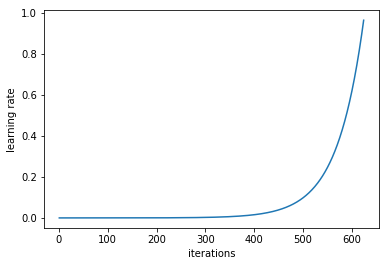

In [44]:
model.sched.plot_lr()

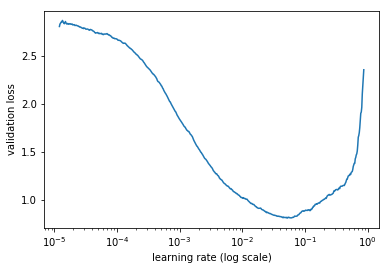

In [45]:
model.sched.plot()

In [46]:
model.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.593998   0.466022   0.829917  


[array([0.46602]), 0.8299166666666666]

In [47]:
model.precompute = False
model.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.5915     0.453929   0.831833  
    1      0.564739   0.444019   0.8335                      
    2      0.563608   0.434597   0.837833                    


[array([0.4346]), 0.8378333333333333]

In [48]:
model.save('224_lastlayer')

In [49]:
model.load('224_lastlayer')

In [50]:
model.unfreeze()

In [51]:
lrf = model.lr_find()

 82%|████████▏ | 613/750 [01:04<00:14,  9.30it/s, loss=2.47] 

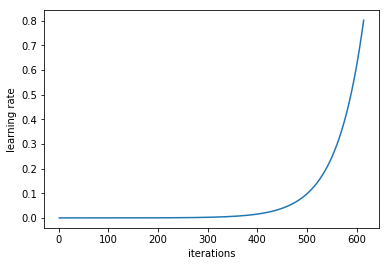

In [52]:
model.sched.plot_lr()

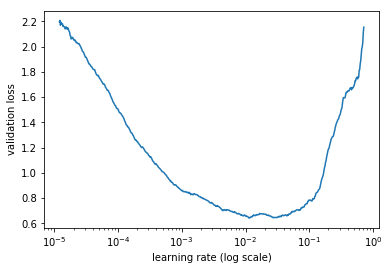

In [53]:
model.sched.plot()

In [54]:
#learning_rates = np.array([1e-4, 1e-3, 1e-2])
learning_rates = np.array([0.0025, 0.005, 0.01])

In [55]:
model.fit(learning_rates, 5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.389756   0.299349   0.8925    
    1      0.341019   0.253853   0.90875                     
    2      0.281865   0.232877   0.915083                    
    3      0.314068   0.25749    0.905                       
    4      0.260013   0.2158     0.92175                     
    5      0.221528   0.204974   0.924333                    
    6      0.208789   0.201438   0.926833                    
    7      0.260181   0.243595   0.909417                    
    8      0.256147   0.214533   0.922167                    
    9      0.23019    0.206014   0.924583                    
    10     0.204031   0.19843    0.927917                    
    11     0.186883   0.191147   0.930833                    
    12     0.172488   0.189014   0.931083                    
    13     0.152145   0.190204   0.930083                    
    14     0.159857   0.188977   0.930667                    
    15     0.218059   0.21

[array([0.20014]), 0.9344166666666667]

In [56]:
model.save('224_all')

In [57]:
model.load('224_all')

In [58]:
log_predictions, y = model.TTA()
probabilities = np.mean(np.exp(log_predictions), 0)
accuracy_np(probabilities, y)

0.9413333333333334

In [59]:
log_predictions, y = model.TTA(is_test=True)
probabilities = np.mean(np.exp(log_predictions), 0)
accuracy_np(probabilities, y)

0.9405